In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import ImageFolder
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import mobilenet_v2
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report




In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



data_dir = '/kaggle/input/colorectal-canc/Dataset 1/Colorectal Cancer '


classes = ['MUS', 'NORM', 'STR']
classes = ['MUS', 'NORM', 'STR']
class_counts = {class_name: 0 for class_name in classes}


for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Count the number of .tif files for each class
    class_counts[class_name] = len([filename for filename in os.listdir(class_path) if filename.endswith('.tif')])

print(class_counts)

images = []
labels = []


for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.tif'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            images.append(image)
            labels.append(class_name)


X = np.array(images)
y = np.array(labels)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




{'MUS': 2000, 'NORM': 2000, 'STR': 2000}


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25, Train Loss: 0.9914, Train Accuracy: 0.5244, Validation Loss: 0.8389, Validation Accuracy: 0.6733
Epoch 2/25, Train Loss: 0.7554, Train Accuracy: 0.7392, Validation Loss: 0.6486, Validation Accuracy: 0.8133
Epoch 3/25, Train Loss: 0.6148, Train Accuracy: 0.8285, Validation Loss: 0.5368, Validation Accuracy: 0.8683
Epoch 4/25, Train Loss: 0.5228, Train Accuracy: 0.8638, Validation Loss: 0.4565, Validation Accuracy: 0.8867
Epoch 5/25, Train Loss: 0.4517, Train Accuracy: 0.8881, Validation Loss: 0.3986, Validation Accuracy: 0.9033
Epoch 6/25, Train Loss: 0.3969, Train Accuracy: 0.9046, Validation Loss: 0.3477, Validation Accuracy: 0.9167
Epoch 7/25, Train Loss: 0.3593, Train Accuracy: 0.9110, Validation Loss: 0.3156, Validation Accuracy: 0.9283
Epoch 8/25, Train Loss: 0.3236, Train Accuracy: 0.9196, Validation Loss: 0.2860, Validation Accuracy: 0.9333
Epoch 9/25, Train Loss: 0.2930, Train Accuracy: 0.9260, Validation Loss: 0.2633, Validation Accuracy: 0.9367
Epoch 10/25, Train 

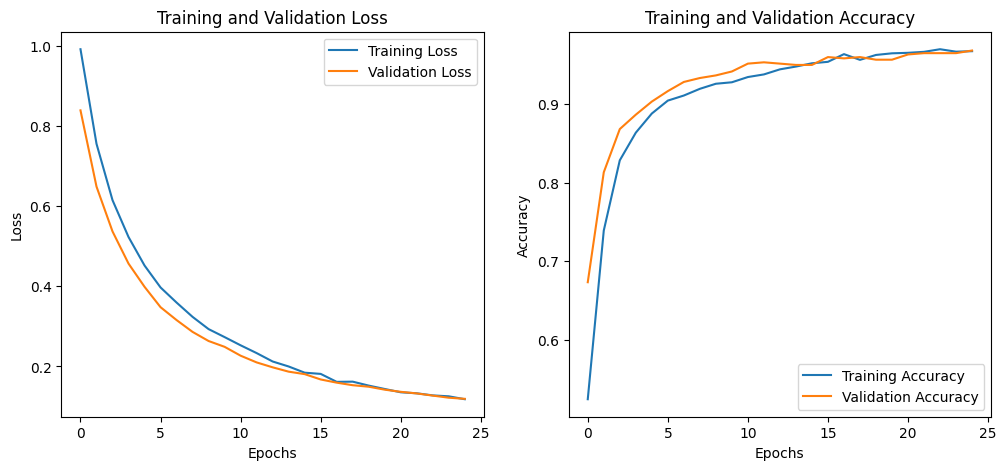

In [5]:
#Running a pre trained model on dataset 1 with the same architecture and hyperparameters as our model from scratch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


# Define hyperparameters
batch_size = 32  # Fixed batch size
learning_rate = 0.0001  # Fixed learning rate
epochs = 25

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure input is a PIL image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformations to your data
X_train_transformed = torch.stack([data_transform(x) for x in X_train])
X_val_transformed = torch.stack([data_transform(x) for x in X_val])
X_test_transformed = torch.stack([data_transform(x) for x in X_test])

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(X_train_transformed, y_train_tensor)
val_dataset = TensorDataset(X_val_transformed, y_val_tensor)
test_dataset = TensorDataset(X_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

# Training and validation loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

  

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()






Test Accuracy: 0.9600
Precision: 0.9618
Recall: 0.9603
F1 Score: 0.9608

Classification Report:

              precision    recall  f1-score   support

         MUS       0.93      0.96      0.95       219
        NORM       0.99      1.00      1.00       187
         STR       0.96      0.92      0.94       194

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



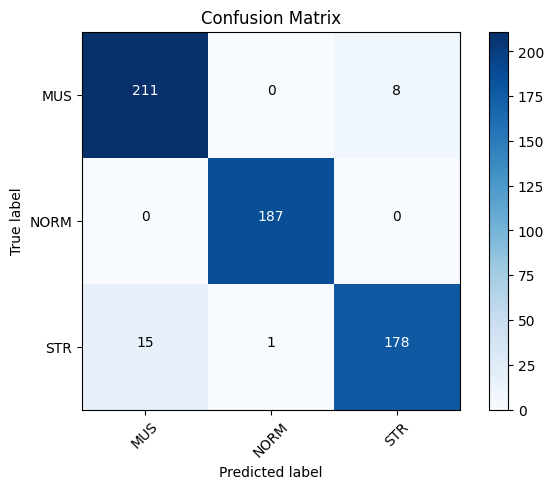

In [6]:
#test set evaluation for pretrained model
model.eval()
test_loss = 0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.4f}')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


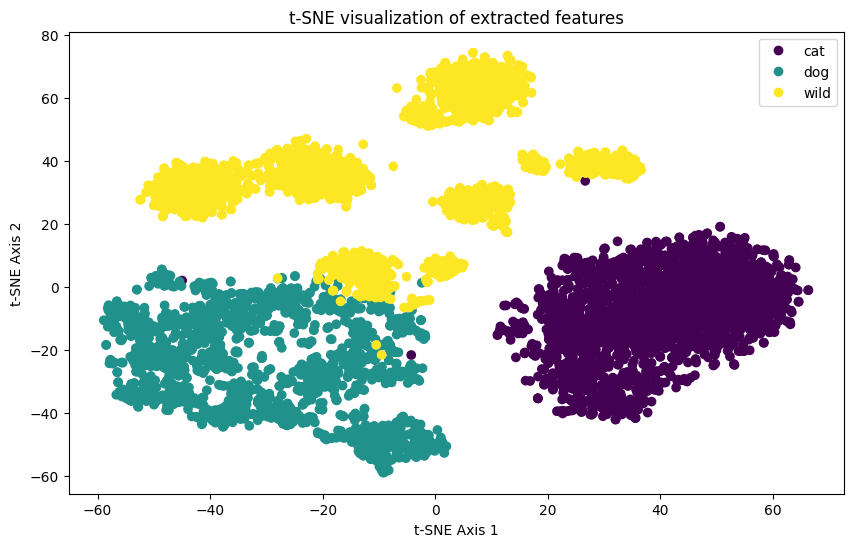

In [7]:
#Feature extraction using a RESNET18 pretrained model on dataset 3
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
data_dir = '/kaggle/input/animal-faces/Dataset 3/Animal Faces'
classes = ['cat', 'dog', 'wild']
images = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(class_name)

X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
])

# Apply transformations to the entire dataset
X_transformed = torch.stack([data_transform(x) for x in X])
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
dataset = TensorDataset(X_transformed, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer
model = model.to(device)

# Feature Extraction
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, y in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            output = output.view(output.size(0), -1)  # Flatten the features
            features.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from the entire dataset
features, labels = extract_features(loader, model)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


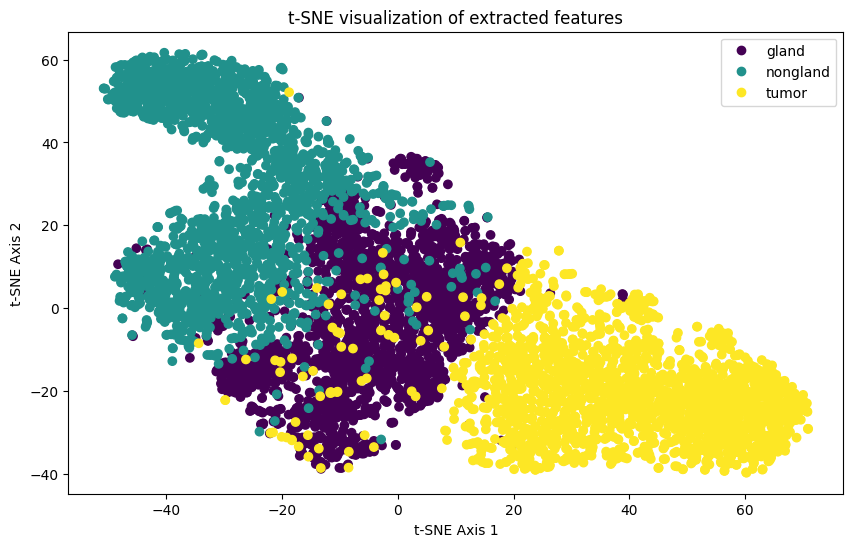

In [8]:
#Feature extraction using a RESNET18 pretrained model on dataset 2

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
data_dir = '/kaggle/input/dataset2/Dataset 2/Prostate Cancer'
classes = ['gland', 'nongland', 'tumor']
images = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(class_name)

X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
])

# Apply transformations to the entire dataset
X_transformed = torch.stack([data_transform(x) for x in X])
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
dataset = TensorDataset(X_transformed, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer
model = model.to(device)

# Feature Extraction
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, y in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            output = output.view(output.size(0), -1)  # Flatten the features
            features.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from the entire dataset
features, labels = extract_features(loader, model)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


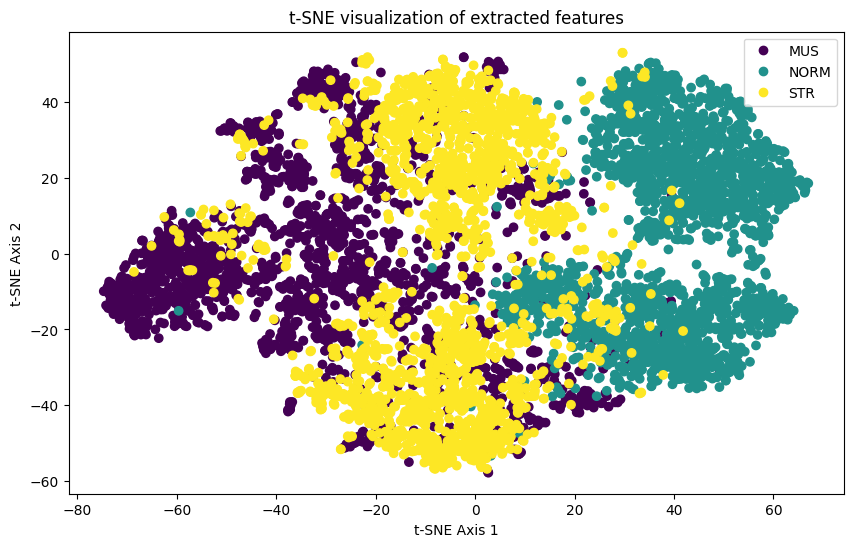

In [10]:
#Feature extraction using a RESNET18 pretrained model on dataset 1
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
data_dir = '/kaggle/input/colorectal-canc/Dataset 1/Colorectal Cancer '
classes = ['MUS', 'NORM', 'STR']
images = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.tif'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(class_name)

X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
])

# Apply transformations to the entire dataset
X_transformed = torch.stack([data_transform(x) for x in X])
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
dataset = TensorDataset(X_transformed, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet-18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer
model = model.to(device)

# Feature Extraction
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, y in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            output = output.view(output.size(0), -1)  # Flatten the features
            features.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from the entire dataset
features, labels = extract_features(loader, model)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()
